<a href="https://colab.research.google.com/github/pradeepprasad/Machine_Learning_Workspace/blob/master/Transfer_Learning_0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **In this version we will unfreeze some of bottom layers of base model to improve accuracy.  **

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
keras = tf.keras
#enable eager execution otherwise instructions for fetching labels will fail
tf.enable_eager_execution()


In [3]:
tf.version

<module 'tensorflow._api.v1.version' from '/usr/local/lib/python3.6/dist-packages/tensorflow_core/_api/v1/version/__init__.py'>

In [0]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()


In [0]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)


In [6]:
ls /root/tensorflow_datasets/cats_vs_dogs/2.0.1

cats_vs_dogs-train.tfrecord-00000-of-00020
cats_vs_dogs-train.tfrecord-00001-of-00020
cats_vs_dogs-train.tfrecord-00002-of-00020
cats_vs_dogs-train.tfrecord-00003-of-00020
cats_vs_dogs-train.tfrecord-00004-of-00020
cats_vs_dogs-train.tfrecord-00005-of-00020
cats_vs_dogs-train.tfrecord-00006-of-00020
cats_vs_dogs-train.tfrecord-00007-of-00020
cats_vs_dogs-train.tfrecord-00008-of-00020
cats_vs_dogs-train.tfrecord-00009-of-00020
cats_vs_dogs-train.tfrecord-00010-of-00020
cats_vs_dogs-train.tfrecord-00011-of-00020
cats_vs_dogs-train.tfrecord-00012-of-00020
cats_vs_dogs-train.tfrecord-00013-of-00020
cats_vs_dogs-train.tfrecord-00014-of-00020
cats_vs_dogs-train.tfrecord-00015-of-00020
cats_vs_dogs-train.tfrecord-00016-of-00020
cats_vs_dogs-train.tfrecord-00017-of-00020
cats_vs_dogs-train.tfrecord-00018-of-00020
cats_vs_dogs-train.tfrecord-00019-of-00020
dataset_info.json
image.image.json
label.labels.txt


In [7]:
print(raw_train)
print(raw_validation)
print(raw_test)


<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>
<DatasetV1Adapter shapes: ((?, ?, 3), ()), types: (tf.uint8, tf.int64)>


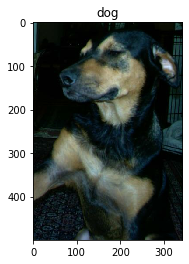

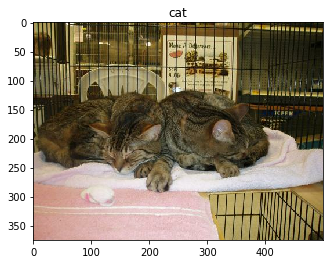

In [8]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))


# **Data formating**

In [0]:
IMG_SIZE = 160 # All images will be resized to 160x160

def format_example(image, label):
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label


In [0]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)


In [0]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000


In [0]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


In [13]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape


TensorShape([Dimension(32), Dimension(160), Dimension(160), Dimension(3)])

# **Get the base model - MobileNet V2**

In [0]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


In [15]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 5, 5, 1280)


In [0]:
base_model.trainable = False


Well! Model is very large in respect to layers. Lets see this.

In [17]:
# Let's take a look at the base model architecture
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# **Adding classifier on top as it is now headless.**

In [18]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


making single prediction

In [19]:
prediction_layer = keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [0]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


Compile the model

In [0]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [22]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [23]:
len(model.trainable_variables)


2

## Lets train model

In [0]:
num_train, num_val, num_test = (
  metadata.splits['train'].num_examples*weight/10
  for weight in SPLIT_WEIGHTS
)


In [25]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)


20/20 [==============================] - 24s 1s/step - loss: 4.9369 - acc: 0.5891


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


initial loss: 4.94
initial accuracy: 0.59


In [27]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)


Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 1420s 2s/step - loss: 2.0149 - acc: 0.7452 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 1323s 2s/step - loss: 1.1089 - acc: 0.8553 - val_loss: 1.2508 - val_acc: 0.8698
Epoch 3/10
582/582 [==============================] - 1300s 2s/step - loss: 0.8177 - acc: 0.8930 - val_loss: 0.9973 - val_acc: 0.8974
Epoch 4/10
582/582 [==============================] - 1293s 2s/step - loss: 0.6794 - acc: 0.9098 - val_loss: 0.9010 - val_acc: 0.9091
Epoch 5/10
582/582 [==============================] - 1310s 2s/step - loss: 0.5984 - acc: 0.9221 - val_loss: 0.6960 - val_acc: 0.9272
Epoch 6/10
582/582 [==============================] - 1299s 2s/step - loss: 0.5375 - acc: 0.9305 - val_loss: 0.7081 - val_acc: 0.9280
Epoch 7/10
582/582 [==============================] - 1299s 2s/step - loss: 0.4954 - acc: 0.9348 - val_loss: 0.6945 - val_acc: 0.9297
Epoch 8/10
582/582 [==============================] - 1316s 2s/st

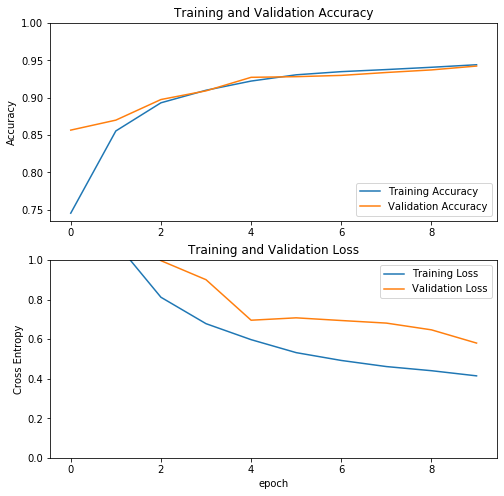

In [29]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Save model

In [0]:
model.save('/content/drive/My Drive/temp/saved_models/transfer_learning_2_hdf5')

# **Lets work on Tuning model**

In [0]:
base_model.trainable = True


In [32]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  155


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])


In [34]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [35]:
len(model.trainable_variables)


58

Train the unfreeze layers which are after 100th layer

In [36]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)


Epoch 10/20
582/582 [==============================] - 1620s 3s/step - loss: 0.3772 - acc: 0.9518 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 11/20
582/582 [==============================] - 1640s 3s/step - loss: 0.2926 - acc: 0.9739 - val_loss: 0.3202 - val_acc: 0.9651
Epoch 12/20
582/582 [==============================] - 1619s 3s/step - loss: 0.2550 - acc: 0.9819 - val_loss: 0.2966 - val_acc: 0.9668
Epoch 13/20
582/582 [==============================] - 1609s 3s/step - loss: 0.2349 - acc: 0.9843 - val_loss: 0.2993 - val_acc: 0.9690
Epoch 14/20
582/582 [==============================] - 1598s 3s/step - loss: 0.2245 - acc: 0.9851 - val_loss: 0.2866 - val_acc: 0.9707
Epoch 15/20
582/582 [==============================] - 1595s 3s/step - loss: 0.2163 - acc: 0.9857 - val_loss: 0.2835 - val_acc: 0.9681
Epoch 16/20
582/582 [==============================] - 1600s 3s/step - loss: 0.2056 - acc: 0.9861 - val_loss: 0.2875 - val_acc: 0.9685
Epoch 17/20
582/582 [==========================

In [0]:
acc += history_fine.history['acc']
val_acc += history_fine.history['val_acc']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


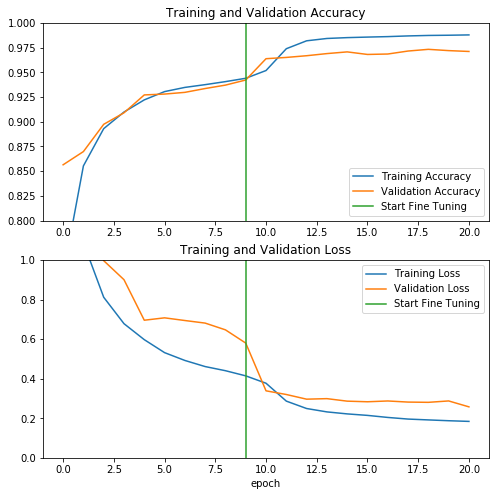

In [38]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [0]:
model.save('/content/drive/My Drive/temp/saved_models/transfer_learning_2_1_hdf5')